<a href="https://colab.research.google.com/github/rickygrosvenor-pramanick/finetuning/blob/main/supervised_finetuning_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q --upgrade \
    "datasets>=2.15.0" \
    "fsspec>=2023.11.0" \
    "huggingface_hub>=0.17.1"

In [2]:
!pip install transformers datasets accelerate torch

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

### 1. Load Data

In [3]:
from datasets import load_dataset

gsm8k = load_dataset("openai/gsm8k", "main", split="train")

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [4]:
gsm8k.shape

(7473, 2)

In [5]:
gsm8k[0].keys()

dict_keys(['question', 'answer'])

### 2. Choose an LLM to Fine-tune
Generation vs. Classification
1. BERT (encoder-only) is great for fixed-label tasks (sentiment, topic, regression) but cannot produce free-form text.
2. GPT-style (causal decoder) models excel at next-token prediction, so they can output the full “Solution:” and “Answer:” blocks you see in GSM8K.
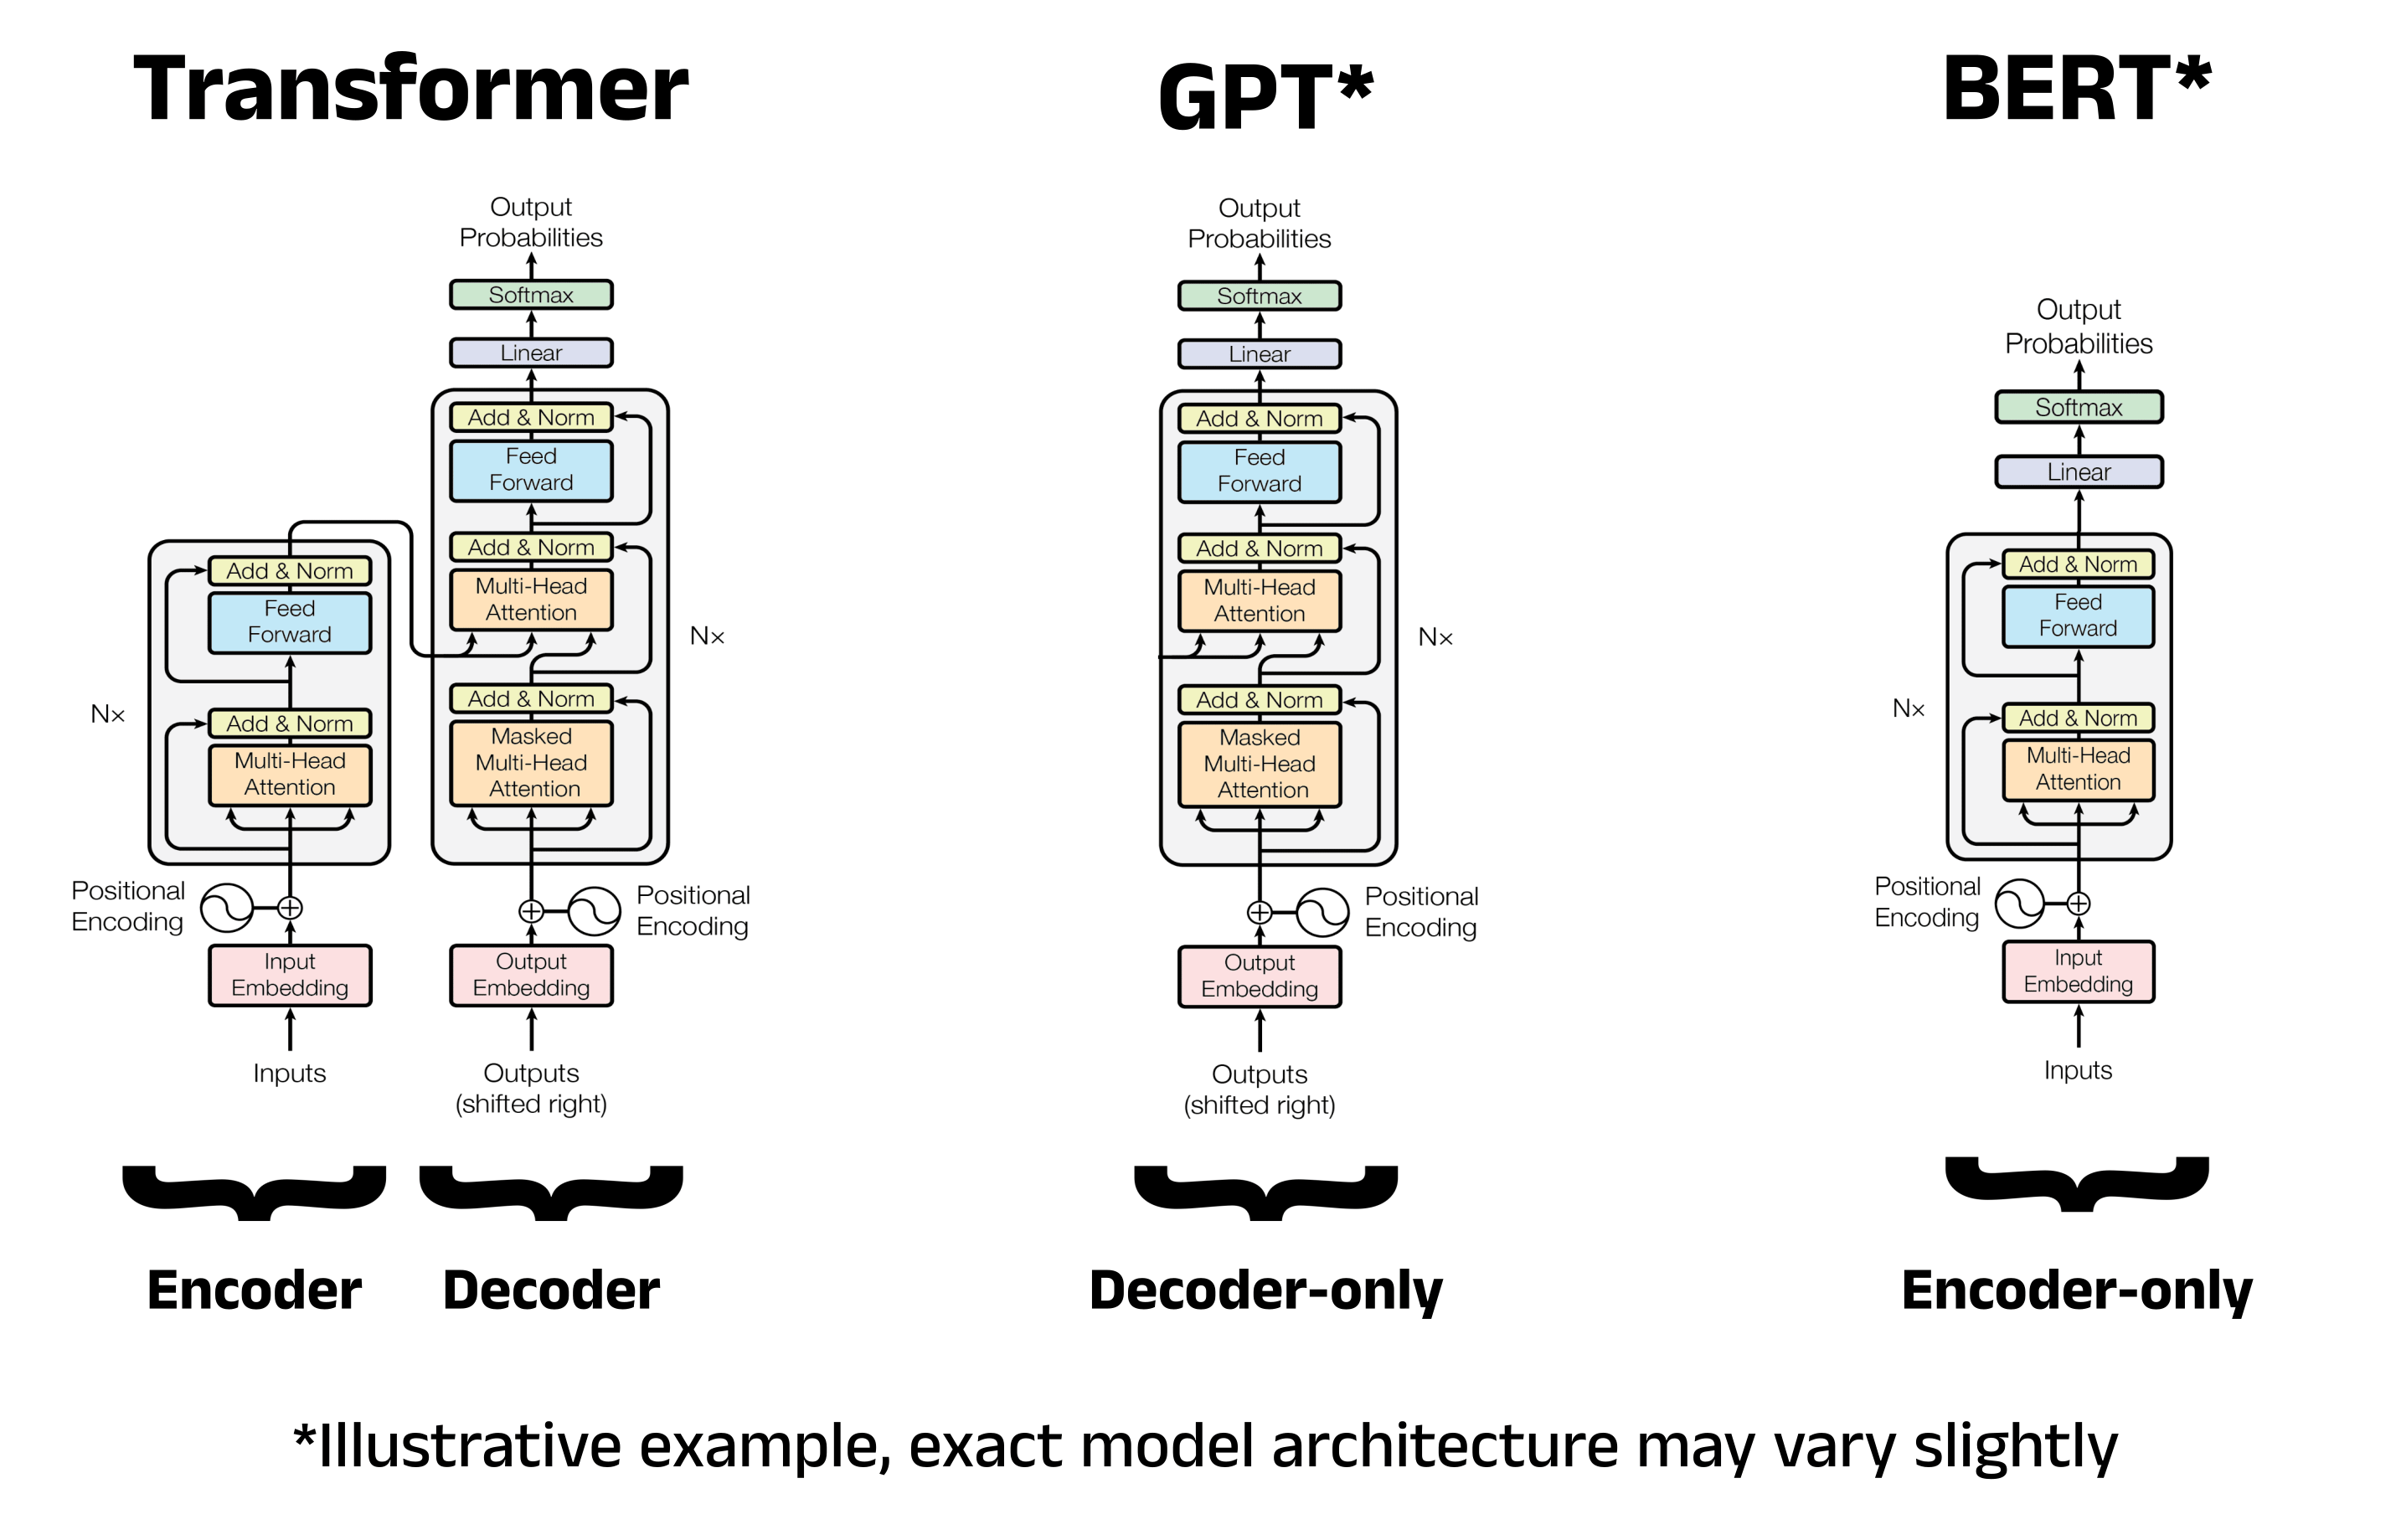

1. Transformer (Vaswani et al., 2017)

**Architecture**: Stacks of self-attention and feed-forward layers, split into an encoder (processes input) and a decoder (generates output)

Key ideas:
* Self-attention lets every token attend to every other token in a sequence in parallel
* Positional encodings inject token order information
* Encoder–decoder framework makes it suitable for sequence-to-sequence tasks (e.g. translation)

1.1 Encoder

* Input: a sequence of token IDs (e.g. words or sub-words).

* Process: each token is embedded (via a learned lookup + positional encoding), then passes through N layers of multi-head self-attention + feed-forward.

* Output: a sequence of contextualized vectors—one vector per input token. These are often called the encoder’s “hidden states” or “embeddings.”

1.2 Decoder

* Input (at training/inference):
  - Previously generated tokens (shifted right) go through the same embedding + positional encoding.

  - Cross-attention: at each layer, the decoder also “looks at” the encoder’s output vectors.

* Process: each decoder layer has

  - Masked self-attention over its own inputs (so it can’t peek at future tokens), cross-attention over the encoder’s outputs, and a feed-forward block.

* Output: at the top, a linear + softmax layer converts each decoder position’s hidden vector into a distribution over the vocabulary—i.e. the next token probabilities.

2. BERT (Devlin et al., 2018)

Built on: The **encoder half of the Transformer**

Pre-training tasks:
* Masked Language Modeling (MLM): randomly mask tokens and predict them using both left and right context, yielding truly bidirectional representations
* Next Sentence Prediction (NSP): predict whether two sentences follow each other, to capture inter-sentence relationships

Use case: fine-tune for downstream understanding tasks (classification, span extraction, sentence similarity)

3. GPT (Radford et al., 2018–2023)

Built on: The decoder half of the Transformer, with causal (left-to-right) masking

Pre-training task
* Autoregressive (causal) language modeling: predict the next token given all previous tokens, enabling fluent text generation

Use case: zero-/few-shot generation, dialogue, code synthesis, plus fine-tune for specific generation or completion tasks

Because GPT is trained as an autoregressive (left-to-right) language model, at every position it must only see—and condition on—the tokens that come before the one it’s trying to predict.

Teacher-forcing setup
* During training, we feed the model the “history” up to token t (i.e. tokens 1…t), and ask it to predict token t+1. By “shifting right,” the decoder input at position t corresponds exactly to the ground-truth token at position t–1, so that the model learns to use only past context.

Prevents leakage
* Without shifting, the model might peek at the true token it’s supposed to predict. Causal masking alone prevents attention to future positions, but shifting makes sure the data alignment lines up: input at slot t = token t–1, target at slot t = token t.

Alignment of logits and labels
* If your sequence is [BOS] w₁ w₂ … wₙ, you actually feed [BOS, w₁, w₂, …, wₙ₋₁] into the decoder, and train it to predict [w₁, w₂, …, wₙ]. That right-shift means your output logits at step t line up with the label token at step t.

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# AutoTokeniser - Reads the model’s config (and vocab files) under the hood and fetches the tokeniser they used
tokeniser = AutoTokenizer.from_pretrained("distilgpt2")
# AutoModelForCausalLM - Loads the model architecture and weights specified by the path
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

#### 2.1 Check Special Tokens in the Tokeniser and add any that may be needed

In [7]:
tokeniser.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}

In [8]:
if tokeniser.pad_token_id is None:
    tokeniser.add_special_tokens({"pad_token": "[PAD]"})
    model.resize_token_embeddings(len(tokeniser))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [9]:
tokeniser.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '[PAD]'}

An example is as such

    ex = {
    "question": "If John has 3 apples and gives 1 away, how many does he have left?",
    "formula": "He starts with 3, gives away 1, so 3 - 1 = 2.",
    "answer": "2"
    }

In [12]:
def preprocess(ex):
    # Builds a single string for a particular data point by concatenating Question - prompt, Solution - Chain of Thought and Answer - Response.
    text  = "Question: " + ex["question"].strip() + "\n"
    text += "Solution:\n" + ex.get("formula","").strip() + "\n"
    text += "Answer: " + ex["answer"].strip()
    return tokeniser(
        text,
        truncation=True,
        max_length=512,
        padding="max_length",
    )

In [13]:
# applies preprocess to each example in the gsm8k train split
tokenised = gsm8k.map(preprocess, batched=False)

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [ ]:
# set labels = input_ids so model learns to reproduce the entire block
tokenised = tokenised.map(lambda ex: {"labels": ex["input_ids"]}, batched=False)